In [1]:
#每张图片有 60 个评分，求平均分作为照片的最终得分
import pandas as pd

ratings = pd.read_excel('SCUT-FBP5500_v2/All_Ratings.xlsx', engine='openpyxl')

filenames = ratings.groupby('Filename').size().index.tolist()

labels = []

for filename in filenames:
    df = ratings[ratings['Filename'] == filename]
    score = round(df['Rating'].mean(), 2)
    labels.append({'Filename': filename, 'score': score})

labels_df = pd.DataFrame(labels)

In [2]:
labels_df

,Filename,score
0,AF1.jpg,2.33
1,AF10.jpg,3.43
2,AF100.jpg,2.90
3,AF1000.jpg,3.97
4,AF1001.jpg,3.73
...,...,...
5495,CM95.jpg,2.13
5496,CM96.jpg,3.05
5497,CM97.jpg,3.05
5498,CM98.jpg,2.40


<BarContainer object of 9 artists>

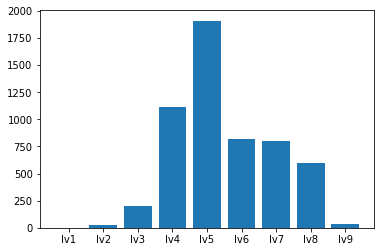

In [3]:
# 查看颜值分布情况
import matplotlib.pyplot as plt
lv1 = [x for x in labels_df['score'] if x<1]
lv2 = [x for x in labels_df['score'] if x>=1 and x<1.5]
lv3 = [x for x in labels_df['score'] if x>=1.5 and x<2]
lv4 = [x for x in labels_df['score'] if x>=2 and x<2.5]
lv5 = [x for x in labels_df['score'] if x>=2.5 and x<3]
lv6 = [x for x in labels_df['score'] if x>=3 and x<3.5]
lv7 = [x for x in labels_df['score'] if x>=3.5 and x<4]
lv8 = [x for x in labels_df['score'] if x>=4 and x<4.5]
lv9 = [x for x in labels_df['score'] if x>=4.5]
plt.bar(['lv1','lv2','lv3','lv4','lv5','lv6','lv7','lv8','lv9'],
       [len(x) for x in [lv1,lv2,lv3,lv4,lv5,lv6,lv7,lv8,lv9]])

In [4]:
#自定义结构化数据集
import os
import torch
from torch.utils import data
from PIL import Image
import numpy as np
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # 将图片转换为Tensor,归一化至[0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 标准化至[-1,1]
])

def imshow(img):
    img=img/2+0.5  #反归一化操作，以便原样显示图片
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()


#定义自己的数据集合
class FlameSet(data.Dataset):
    def __init__(self,root):
        # 所有图片的绝对路径
        imgs_root=os.listdir(root)
        imgs=[]
        for k in imgs_root:
            imgs.append((os.path.join(root,k),float(labels_df[labels_df['Filename'] == k].score)))
        self.imgs=imgs
        self.transforms=transform

    def __getitem__(self, index):
        img_path,label = self.imgs[index]
        pil_img = Image.open(img_path)
        if self.transforms:
            data = self.transforms(pil_img)
        else:
            pil_img = np.asarray(pil_img)
            data = torch.from_numpy(pil_img)
        return data,label

    def __len__(self):
        return len(self.imgs)


trainset=FlameSet('./SCUT-FBP5500_v2/Images_train')
testset=FlameSet('./SCUT-FBP5500_v2/Images_test')

In [5]:
#载入训练集和测试集
from torch.utils.data import DataLoader

trainloader=DataLoader(trainset,batch_size=4,shuffle=True,num_workers=0)
testloader=DataLoader(testset,batch_size=4,shuffle=False,num_workers=0)

In [6]:
len(trainloader)

1200

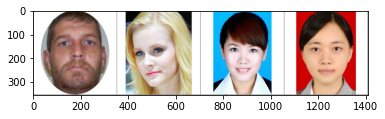

torch.Size([4])

In [7]:
import torchvision
dataiter=iter(trainloader)
images,labels=dataiter.next()

imshow(torchvision.utils.make_grid(images))
#print(''.join('%5s'% labels[j] for j in range(4)))
labels.size()

In [8]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
#定义卷积神经网络的网络模型
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 36, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.aap=nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(36, 1)
        
    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x=self.aap(x)
        x=x.view(x.shape[0],-1)
        x=self.fc1(x)
        x = x.squeeze(-1)
        return x

In [10]:
net=Net()
net=net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 36, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (aap): AdaptiveAvgPool2d(output_size=1)
  (fc1): Linear(in_features=36, out_features=1, bias=True)
)


In [11]:
import torch.optim as optim

#定义超参数
lr=0.01  #学习率
momentum=0.9  #动量（惯性）
num_epoches=10

criterion=torch.nn.MSELoss() #损失函数
optimizer=optim.SGD(net.parameters(),lr=lr,momentum=momentum)  #选择随机梯度下降优化器

#为了更好地求得全局最优值，这里定义一个动态调整学习率的方法

def ajust_learning_rate(optimizer,lr):
    for param_group in optimizer.param_groups:
        param_group['lr']=lr

In [12]:
for epoch in range(num_epoches):
    running_loss=0.0
    if epoch%2==0:
        lr=lr*0.9
        ajust_learning_rate(optimizer,lr)
    for i,data in enumerate(trainloader,0):
        #获取训练数据
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        
        #将上一次的权重参数清零
        optimizer.zero_grad()
        
        #正向及反向传播
        outputs=net(inputs)
        loss=criterion(outputs.float(),labels.float())
        loss.backward()
        
        #更新权重参数
        optimizer.step()
        
        #显示损失值
        
        running_loss+=loss.item()
        if i%200==199:  #print every 2000 min-batches
            print('[%d, %5d] loss:%.3f'%(epoch+1,i+1,running_loss/2000))
            running_loss=0.0
print('训练结束')

[1,   200] loss:0.071
[1,   400] loss:0.041
[1,   600] loss:0.041
[1,   800] loss:0.040
[1,  1000] loss:0.040
[1,  1200] loss:0.039
[2,   200] loss:0.038
[2,   400] loss:0.037
[2,   600] loss:0.037
[2,   800] loss:0.041
[2,  1000] loss:0.037
[2,  1200] loss:0.041
[3,   200] loss:0.037
[3,   400] loss:0.037
[3,   600] loss:0.034
[3,   800] loss:0.039
[3,  1000] loss:0.035
[3,  1200] loss:0.038
[4,   200] loss:0.035
[4,   400] loss:0.036
[4,   600] loss:0.035
[4,   800] loss:0.038
[4,  1000] loss:0.034
[4,  1200] loss:0.036
[5,   200] loss:0.036
[5,   400] loss:0.036
[5,   600] loss:0.037
[5,   800] loss:0.037
[5,  1000] loss:0.036
[5,  1200] loss:0.033
[6,   200] loss:0.035
[6,   400] loss:0.034
[6,   600] loss:0.038
[6,   800] loss:0.035
[6,  1000] loss:0.031
[6,  1200] loss:0.038
[7,   200] loss:0.034
[7,   400] loss:0.032
[7,   600] loss:0.035
[7,   800] loss:0.039
[7,  1000] loss:0.035
[7,  1200] loss:0.035
[8,   200] loss:0.034
[8,   400] loss:0.035
[8,   600] loss:0.035
[8,   800]

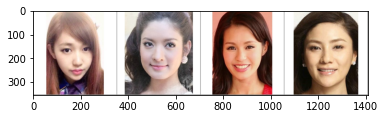

GroundTruth:   3.87  3.85  3.52  3.65


In [13]:
#获取图片真实标签
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(4)))

In [14]:
#获取对应图片的预测标签

images, labels = images.to(device), labels.to(device)
outputs = net(images)

print('Predicted: ', ' '.join('%5s' % outputs[j].item() for j in range(4)))

Predicted:  2.8456404209136963 3.2383248805999756 3.174682855606079 3.4449663162231445


In [15]:
#测试模型

with torch.no_grad():
    xys=[]
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        for i in range(4):
            xys.append([labels[i].item(),outputs[i].item()])

In [16]:
xys

[[3.87, 2.8456404209136963],
 [3.85, 3.2383248805999756],
 [3.52, 3.174682855606079],
 [3.65, 3.4449663162231445],
 [3.52, 3.1657564640045166],
 [4.12, 3.2015926837921143],
 [2.72, 3.0060319900512695],
 [3.8, 3.4399032592773438],
 [2.87, 3.3251116275787354],
 [2.58, 3.1320812702178955],
 [3.3, 3.183351993560791],
 [3.82, 3.361980438232422],
 [3.88, 3.2409656047821045],
 [3.12, 3.108713150024414],
 [3.05, 2.941136598587036],
 [4.57, 3.558302402496338],
 [3.15, 2.7990002632141113],
 [3.25, 3.2090368270874023],
 [2.88, 2.5630879402160645],
 [1.42, 2.540066957473755],
 [3.48, 3.435209274291992],
 [4.18, 3.3996291160583496],
 [3.77, 3.194505453109741],
 [1.98, 3.0521559715270996],
 [4.02, 2.991696357727051],
 [4.07, 3.370114803314209],
 [4.17, 3.2597908973693848],
 [4.08, 2.981564521789551],
 [2.85, 3.336824417114258],
 [4.07, 3.3208062648773193],
 [2.87, 3.2318339347839355],
 [4.08, 3.114966869354248],
 [3.55, 2.9388673305511475],
 [3.8, 3.289804220199585],
 [3.03, 3.2142839431762695],
 [3

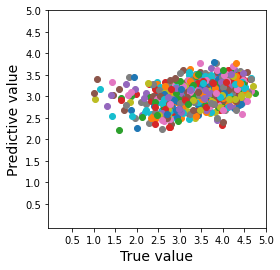

In [17]:
import matplotlib.pyplot as plt
plt.xlabel('True value', fontsize=14)
plt.ylabel('Predictive value', fontsize=14)
plt.axis('scaled')
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.yticks(np.arange(0.5, 5.5, 0.5))
for xy in xys:
    plt.scatter(xy[0], xy[1])
plt.show()

In [18]:
torch.save(net, './FBP/net3.pth')

In [19]:
torch.save(net.state_dict(), './FBP/net3_2.pth')